In [1]:
import cv2
import cv2.aruco as aruco
from typing import Sequence, cast
import awkward as ak
from pathlib import Path
import numpy as np
from typing import Final
from matplotlib import pyplot as plt
from cv2.typing import MatLike

In [2]:
A_PATH = Path("output/af_03.parquet")
B_PATH = Path("output/ae_08.parquet")

a_params = ak.from_parquet(A_PATH)[0]
b_params = ak.from_parquet(B_PATH)[0]
display(a_params)
display(b_params)

<Record {camera_matrix: [...], ...} type='{camera_matrix: var * var * float...'>

<Record {camera_matrix: [...], ...} type='{camera_matrix: var * var * float...'>

In [ ]:
def create_new_aruco_marker_origin(marker_length: float):
    """
    Create a new ArUco marker origin with the given length.

    0 -> x
    |
    v
    y

    0---1
    |   |
    3---2

    So that the center of the marker is the origin for this PnP problem.

    Args:
        marker_length: The length of the marker.
    """
    return np.array(
        [
            [-marker_length / 2, marker_length / 2, 0],
            [marker_length / 2, marker_length / 2, 0],
            [marker_length / 2, -marker_length / 2, 0],
            [-marker_length / 2, -marker_length / 2, 0],
        ]
    ).astype(np.float32)


DICTIONARY: Final[int] = aruco.DICT_4X4_50
# 400mm
MARKER_LENGTH: Final[float] = 0.4
aruco_dict = aruco.getPredefinedDictionary(DICTIONARY)
detector = aruco.ArucoDetector(
    dictionary=aruco_dict, detectorParams=aruco.DetectorParameters()
)

In [4]:
a_img = cv2.imread(str(Path("dumped/marker/video-20241205-152716-board.png")))
a_mtx = ak.to_numpy(a_params["camera_matrix"])
a_dist = ak.to_numpy(a_params["distortion_coefficients"])

b_img = cv2.imread(str(Path("dumped/marker/video-20241205-152721-board.png")))
b_mtx =  ak.to_numpy(b_params["camera_matrix"])
b_dist = ak.to_numpy(b_params["distortion_coefficients"])

In [5]:
a_corners, a_ids, _a_rejected = detector.detectMarkers(a_img)
b_corners, b_ids, _b_rejected = detector.detectMarkers(b_img)

In [ ]:
a_corners

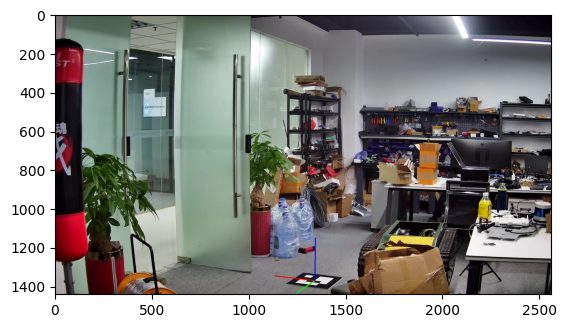

In [6]:
ok, a_rvec, a_tvec = cv2.solvePnP(create_new_aruco_marker_origin(MARKER_LENGTH), a_corners[0], a_mtx, a_dist)
if not ok:
    raise ValueError("Failed to solve PnP for A")
a_img_output =  cv2.drawFrameAxes(a_img, a_mtx, a_dist, a_rvec, a_tvec, MARKER_LENGTH)
plt.imshow(cv2.cvtColor(a_img_output, cv2.COLOR_BGR2RGB))

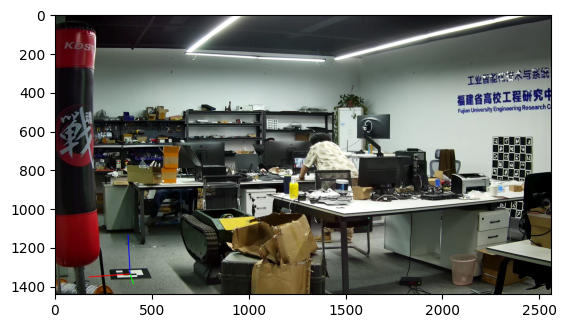

In [7]:
ok, b_rvec, b_tvec = cv2.solvePnP(create_new_aruco_marker_origin(MARKER_LENGTH), b_corners[0], b_mtx, b_dist)
if not ok:
    raise ValueError("Failed to solve PnP for B")
b_img_output =  cv2.drawFrameAxes(b_img, b_mtx, b_dist, b_rvec, b_tvec, MARKER_LENGTH)
plt.imshow(cv2.cvtColor(b_img_output, cv2.COLOR_BGR2RGB))

In [13]:
from typing import TypeVar, Union


T = TypeVar("T")


def create_transform_matrix(rvec: MatLike, tvec: MatLike, dtype: type = np.float32):
    assert rvec.shape == (3, 1)
    assert tvec.shape == (3, 1)
    R, _ = cv2.Rodrigues(rvec)
    transform = np.eye(4, dtype=dtype)
    transform[:3, :3] = R
    transform[:3, 3] = tvec.flatten()
    return transform


def extract_translation(transform: MatLike):
    assert transform.shape == (4, 4)
    return transform[:3, 3]


def extract_rotation(transform: MatLike):
    assert transform.shape == (4, 4)
    return transform[:3, :3]

In [14]:
a_trans = create_transform_matrix(a_rvec, a_tvec)
display(a_trans)

array([[-0.873619  , -0.48628688, -0.01774581,  0.69867176],
       [-0.05326224,  0.13180795, -0.9898433 ,  0.84924215],
       [ 0.48368686, -0.86380076, -0.14105067,  5.540431  ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [15]:
np.linalg.inv(a_trans)

array([[-0.87361896, -0.05326224,  0.48368683, -2.024228  ],
       [-0.48628688,  0.13180795, -0.86380076,  5.0136466 ],
       [-0.01774581, -0.9898433 , -0.14105067,  1.6344967 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [16]:
# Converts a rotation matrix to a rotation vector or vice versa
a_rmtx, _ = cv2.Rodrigues(a_rvec)
b_rmtx, _ = cv2.Rodrigues(b_rvec)
a_camera_coord = -(a_rmtx.T@ a_tvec)
b_camera_coord = -(b_rmtx.T @ b_tvec)
distance = np.linalg.norm(a_camera_coord - b_camera_coord)
a_distance = np.linalg.norm(a_camera_coord)
b_distance = np.linalg.norm(b_camera_coord)
display("d_ab={:.4}m a={:.4}m b={:.4}m".format(distance, a_distance, b_distance))
display("a_coord={}".format(a_camera_coord.T))
display("b_coord={}".format(b_camera_coord.T))

'd_ab=2.558m a=5.649m b=5.965m'

'a_coord=[[-2.0242281   5.01364639  1.63449661]]'

'b_coord=[[0.41154539 5.77171434 1.45086239]]'